In [190]:
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import librosa
import joblib
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.base import clone
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import StandardScaler, PowerTransformer, MinMaxScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

warnings.simplefilter("ignore")

plt.rcParams['figure.figsize'] = (12, 5)

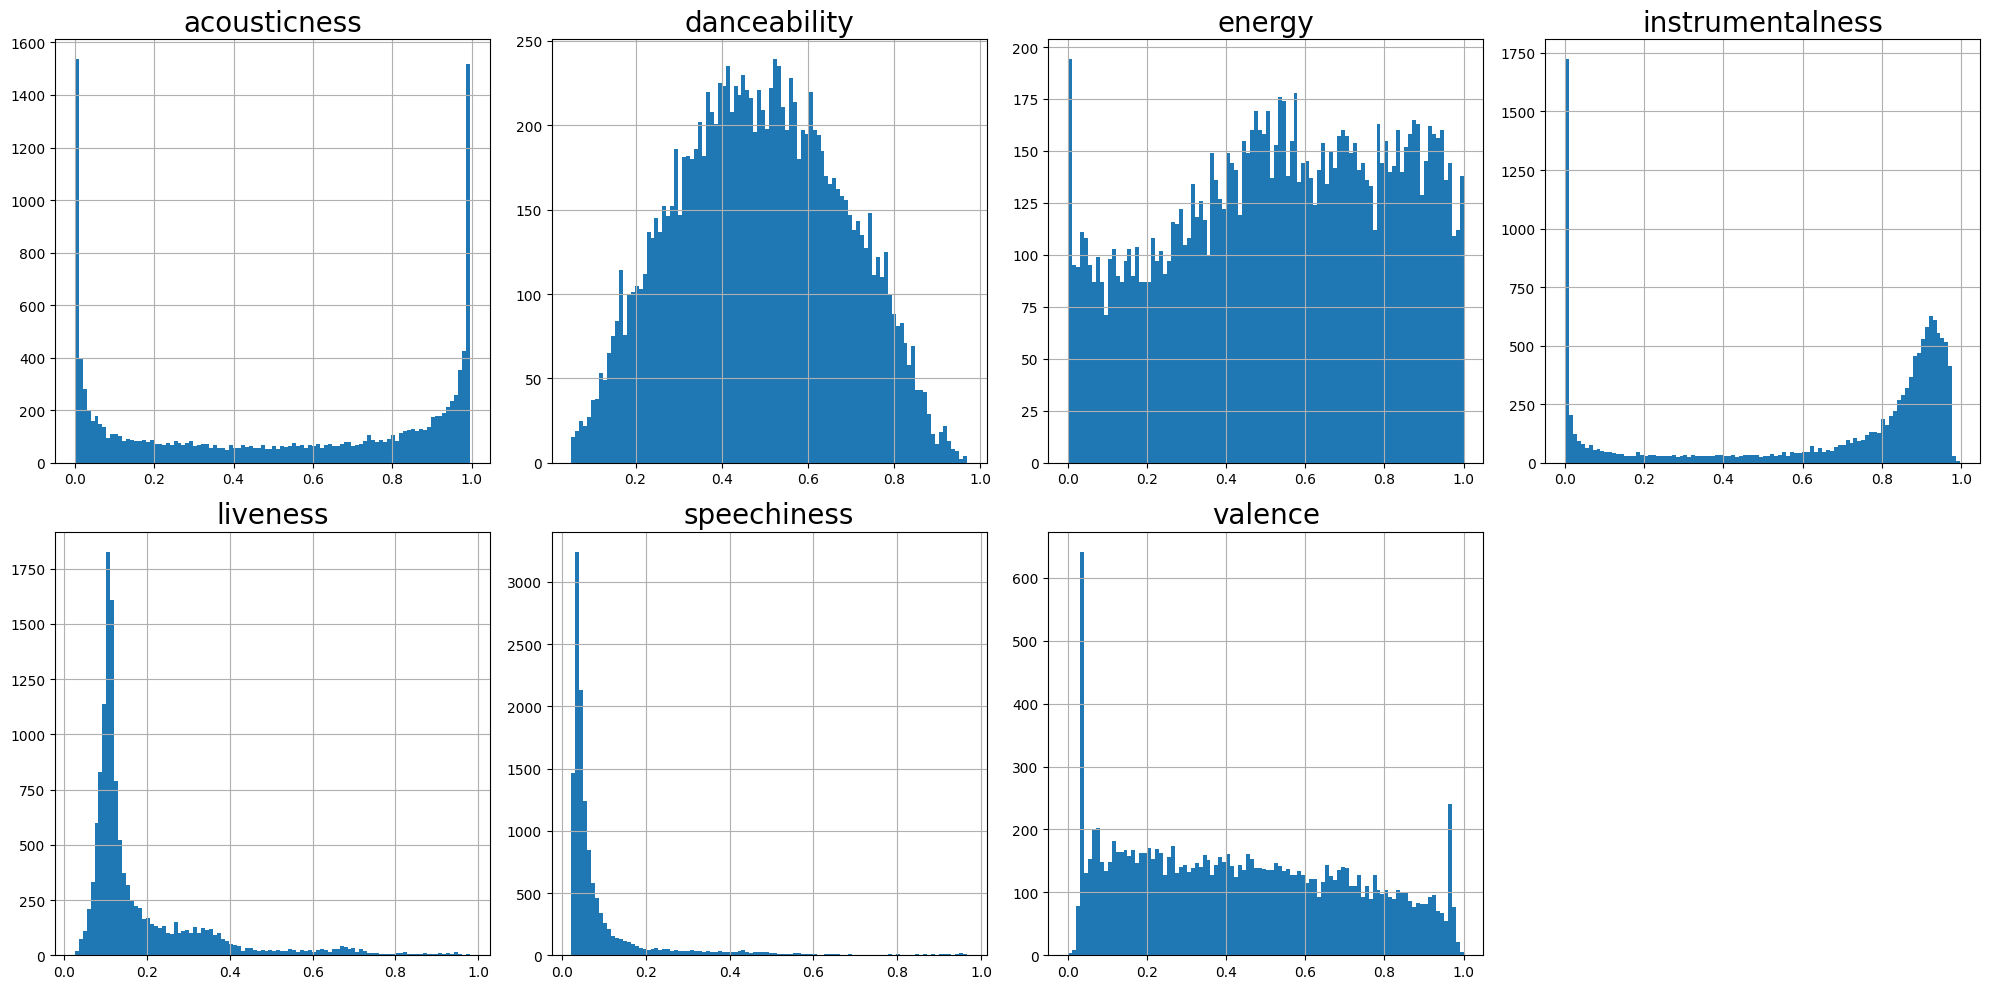

                    count  mean   std   min   25%   50%   75%   max
acousticness      13129.0  0.52  0.38  0.00  0.10  0.57  0.92  1.00
danceability      13129.0  0.49  0.19  0.05  0.34  0.49  0.63  0.97
energy            13129.0  0.54  0.28  0.00  0.32  0.55  0.78  1.00
instrumentalness  13129.0  0.64  0.36  0.00  0.32  0.84  0.92  1.00
liveness          13129.0  0.19  0.16  0.03  0.10  0.12  0.21  0.98
speechiness       13129.0  0.10  0.14  0.02  0.04  0.05  0.09  0.97
valence           13129.0  0.44  0.28  0.00  0.20  0.42  0.67  1.00


In [188]:
# extract the features from the echonest file
base_dir = '../A4/fma_metadata'  # change this to your own directory
echonest_raw = pd.read_csv(f'{base_dir}/echonest.csv', index_col=0, header=[0, 1, 2])

# extract only the target features
echonest_features = echonest_raw['echonest', 'audio_features']

# drop tempo (will be a model input not target)
echonest_features.drop('tempo', axis=1, inplace=True)

def plot_hist(df):
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    for i, (col, ax) in enumerate(zip(df.columns, axes.flatten())):
        df[col].hist(ax=ax, bins=100)
        ax.set_title(col, fontsize=20)
    axes.flatten()[-1].axis('off')
    plt.tight_layout()
    plt.show()

plot_hist(echonest_features)

print(echonest_features.describe().T.round(2))

### EchoNest Feature Standardization
Balancing the distribution of scores before thresholding to create labels.

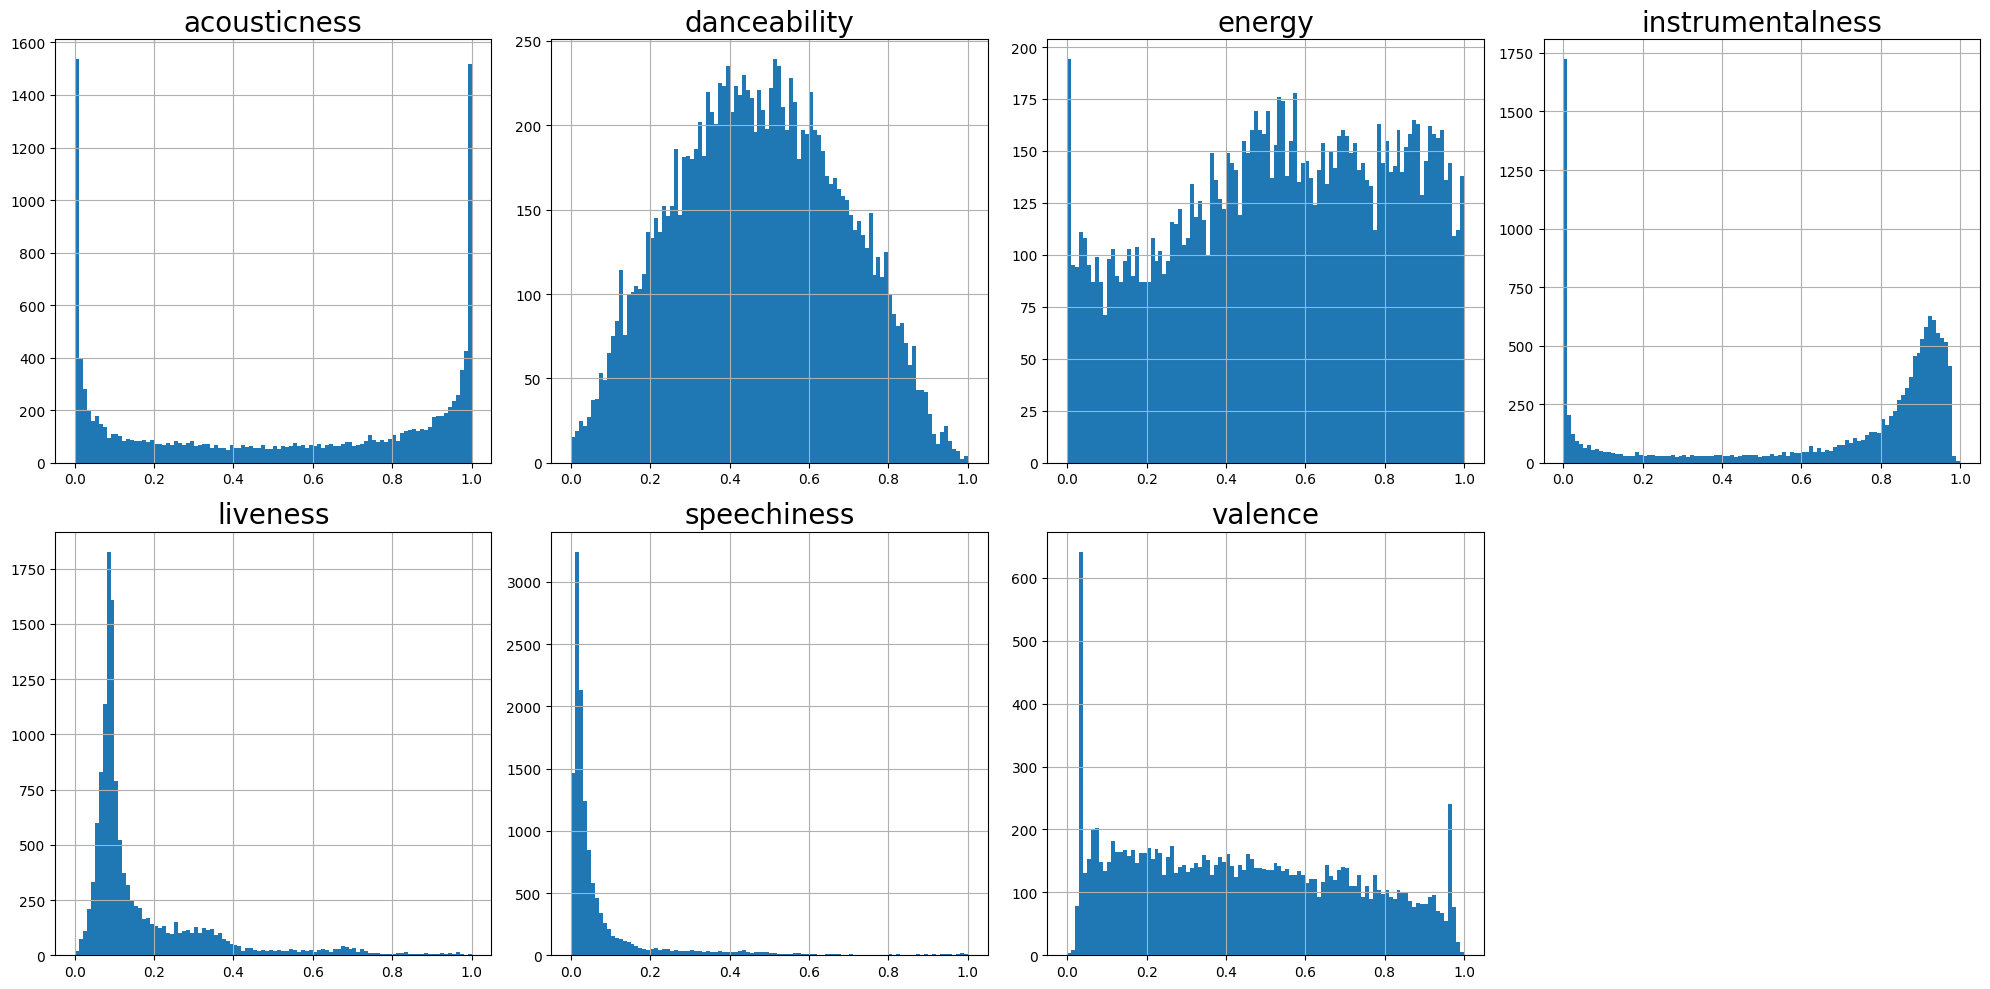

In [196]:
mms = MinMaxScaler()
en_feats_standard = pd.DataFrame(mms.fit_transform(echonest_features),
                                 columns=echonest_features.columns,
                                 index=echonest_features.index)

plot_hist(en_feats_standard)

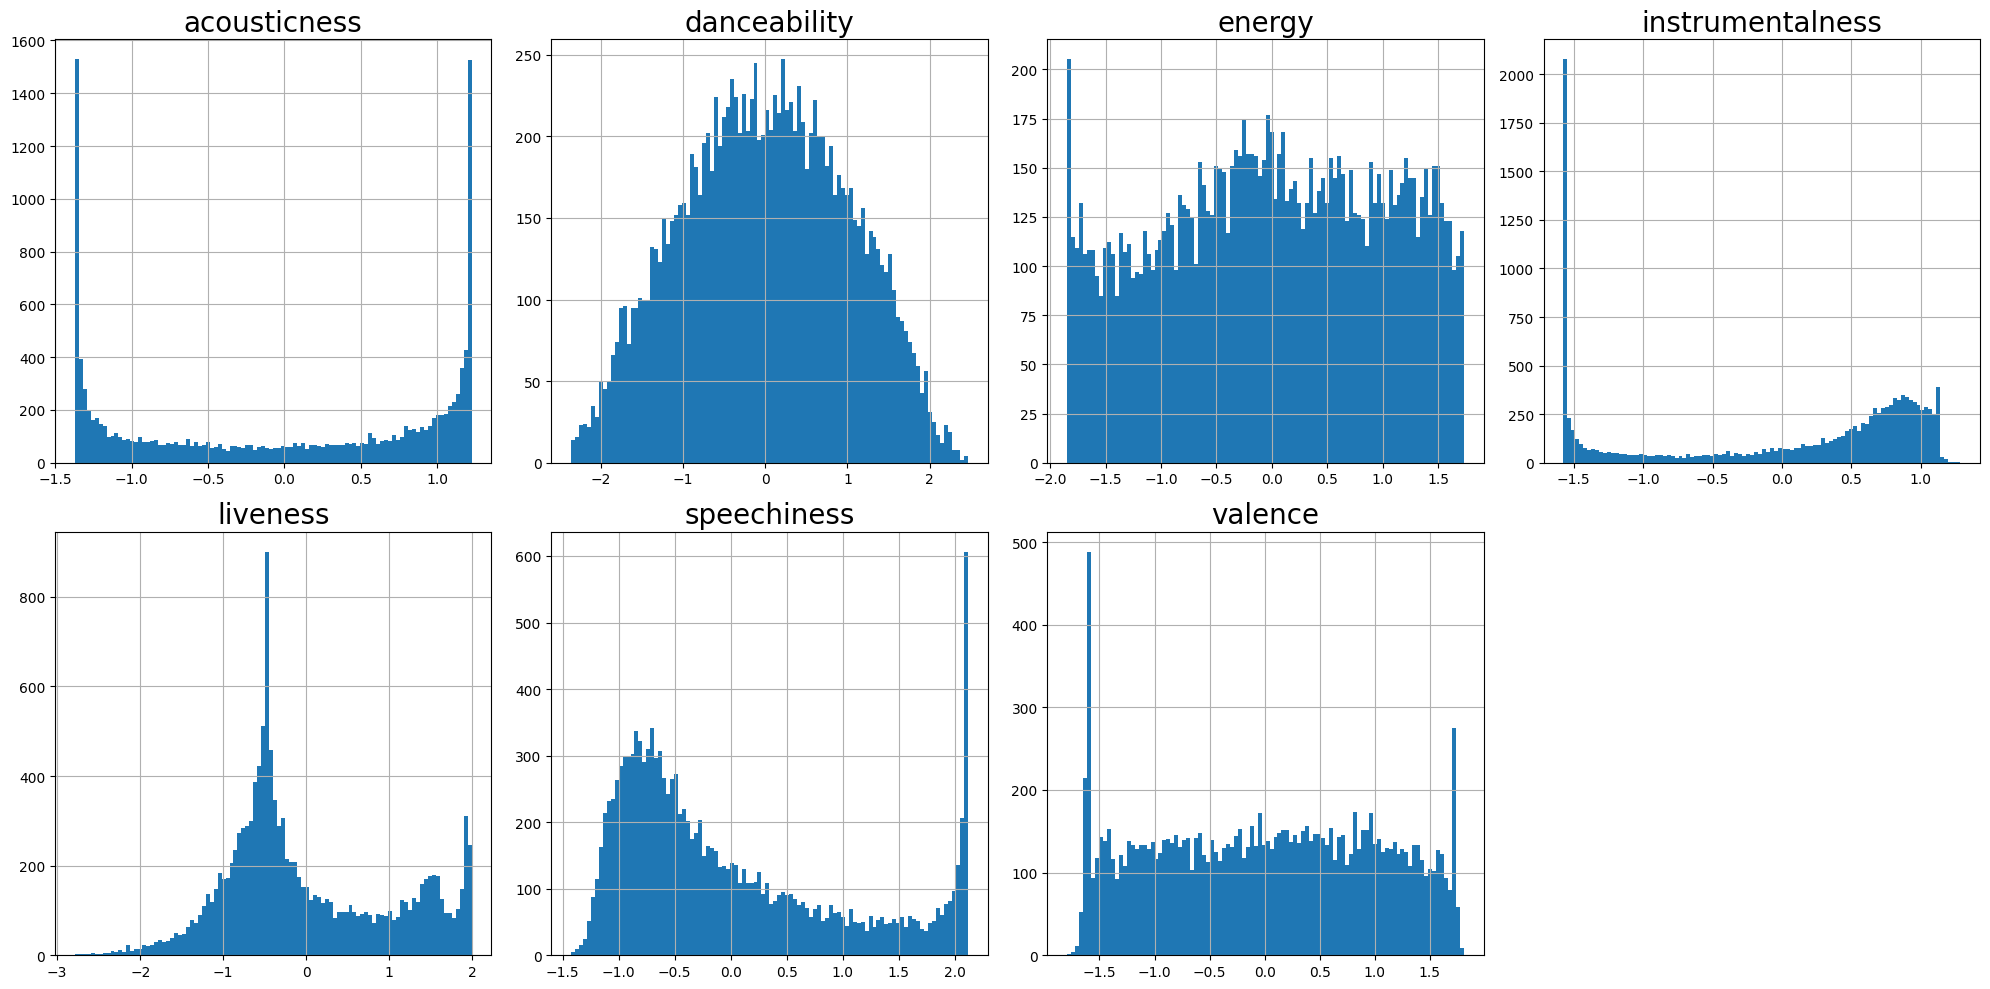

In [197]:
pt = PowerTransformer()
en_feats_gaussian = pd.DataFrame(pt.fit_transform(echonest_features),
                                 columns=echonest_features.columns,
                                 index=echonest_features.index)

plot_hist(en_feats_gaussian)

### Thresholding EchoNest Scores
Converting echonest numeric scores to binary tags by thresholding at: $mean + coeff * std$

In [198]:
def generate_echonest_labels(df, coeff=0.5, output_path='data/echonest_labels.csv'):
    """ Generate binary labels from numeric echonest scores and save to a csv file.
        Scores above the mean + coeff*std are considered '1', otherwise '0'. 
        Returns a list of the binary labels. """

    binary_tags = df.apply(lambda x: (x > x.mean() + coeff*x.std()).astype(int), axis=0)

    EN_feature_mapping = {
        "acousticness": "acoustic",
        "danceability": "danceable",
        "energy": "energetic",
        "instrumentalness": "instrumental",
        "liveness": "lively",
        "speechiness": "speechy",
        "valence": "happy"
    }
    binary_tags.rename(columns=EN_feature_mapping, inplace=True)
    binary_tags.to_csv(output_path)

    return list(EN_feature_mapping.values())

In [199]:
label_names = generate_echonest_labels(en_feats_standard, coeff=0.5, output_path='data/echonest_labels_std.csv')
_ = generate_echonest_labels(en_feats_gaussian, coeff=0.5, output_path='data/echonest_labels_gaussian.csv')

print(label_names)

['acoustic', 'danceable', 'energetic', 'instrumental', 'lively', 'speechy', 'happy']


### Build Dataset
- Feature extraction with Librosa for model inputs (X_train/X_test)
- Labelling tracks with genre and echonest tags (Y_train/Y_test)

In [245]:
def get_labels(from_disk=False, tags_path='data/echonest_labels.csv', save_path='features/targets.npy'):
    """ Get echonest tags from csv file. """
    
    if not from_disk:
        tag_df = pd.read_csv(tags_path, index_col='track_id')

        targets = []

        for idx, fname in enumerate(get_fnames()):
            track_id = int(os.path.basename(fname).split(".")[0])
            match = tag_df[tag_df.index == track_id]
            if match.empty:
                continue
            
            echonest_tags = match.values.tolist()[0]
            targets.append(echonest_tags)

        np.save(save_path, targets)

    y = np.load(save_path)
    return y


def get_fnames(base_dir):
    """ Get list of audio track file paths. """
    fnames = []
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith('.wav'):
                file_path = os.path.join(root, file)
                fnames.append(file_path)
    return fnames


def is_valid_track(fname, tags_path='data/echonest_labels.csv'):
    """ Check if the track ID is in the echonest tags csv file. """
    track_id = int(os.path.basename(fname).split(".")[0])
    tag_df = pd.read_csv(tags_path, index_col='track_id')
    return not tag_df[tag_df.index == track_id].empty


def get_audio_features(audio_dir='', from_disk=True):
    """ Get audio features (model inputs) using librosa. """
    
    if not from_disk:
        feats_mean_mfcc = []
        feats_std_mfcc = []
        feats_mean_chroma = []
        feats_std_chroma = []
        feats_tempo = []
        feats_mean_contrast = []
        feats_std_contrast = []
        feats_mean_mel = []
        feats_std_mel = []
        feats_mean_tonnetz = []
        feats_std_tonnetz = []
        feats_mean_rms = []
        feats_std_rms = []
        feats_mean_zcr = []
        feats_std_zcr = []

        total = 0
        skipped = 0

        # Iterate over audio files to extract features (model inputs) and targets/labels
        for idx, fname in enumerate(get_fnames(audio_dir)):
            total += 1
            if not is_valid_track(fname):
                skipped += 1
                continue
            
            print(f'Extracting features for track {idx}', end='\r')
            audio, srate = librosa.load(fname, res_type='kaiser_fast')

            mfcc_matrix = librosa.feature.mfcc(y=audio, sr=srate, n_mfcc=40)
            mean_mfcc = np.mean(mfcc_matrix, axis=1)
            std_mfcc = np.std(mfcc_matrix, axis=1)
            feats_mean_mfcc.append(mean_mfcc)
            feats_std_mfcc.append(std_mfcc)

            chroma_cqt = librosa.feature.chroma_cqt(y=audio, sr=srate, n_chroma=12)
            mean_chroma = np.mean(chroma_cqt, axis=1)
            std_chroma = np.std(chroma_cqt, axis=1)
            feats_mean_chroma.append(mean_chroma)
            feats_std_chroma.append(std_chroma)

            tempo, _ = librosa.beat.beat_track(y=audio, sr=srate)
            feats_tempo.append(tempo)

            contrast = librosa.feature.spectral_contrast(y=audio, sr=srate, n_bands=6)
            mean_contrast = np.mean(contrast, axis=1)
            std_contrast = np.std(contrast, axis=1)
            feats_mean_contrast.append(mean_contrast)
            feats_std_contrast.append(std_contrast)

            mel = librosa.feature.melspectrogram(y=audio, sr=srate, n_mels=64)
            mean_mel = np.mean(mel, axis=1)
            std_mel = np.std(mel, axis=1)
            feats_mean_mel.append(mean_mel)
            feats_std_mel.append(std_mel)

            tonnetz = librosa.feature.tonnetz(y=audio, sr=srate)
            mean_tonnetz = np.mean(tonnetz, axis=1)
            std_tonnetz = np.std(tonnetz, axis=1)
            feats_mean_tonnetz.append(mean_tonnetz)
            feats_std_tonnetz.append(std_tonnetz)

            rms = librosa.feature.rms(y=audio)
            mean_rms = np.mean(rms, axis=1)
            std_rms = np.std(rms, axis=1)
            feats_mean_rms.append(mean_rms)
            feats_std_rms.append(std_rms)

            zcr = librosa.feature.zero_crossing_rate(y=audio)
            mean_zcr = np.mean(zcr, axis=1)
            std_zcr = np.std(zcr, axis=1)
            feats_mean_zcr.append(mean_zcr)
            feats_std_zcr.append(std_zcr)

        # save to disk to avoid re-computing
        np.save(f'features/feats_mean_mfcc.npy', feats_mean_mfcc)
        np.save(f'features/feats_std_mfcc.npy', feats_std_mfcc)
        np.save(f'features/feats_mean_chroma.npy', feats_mean_chroma)
        np.save(f'features/feats_std_chroma.npy', feats_std_chroma)
        np.save(f'features/feats_tempo.npy', feats_tempo)
        np.save(f'features/feats_mean_contrast.npy', feats_mean_contrast)
        np.save(f'features/feats_std_contrast.npy', feats_std_contrast)
        np.save(f'features/feats_mean_mel.npy', feats_mean_mel)
        np.save(f'features/feats_std_mel.npy', feats_std_mel)
        np.save(f'features/feats_mean_tonnetz.npy', feats_mean_tonnetz)
        np.save(f'features/feats_std_tonnetz.npy', feats_std_tonnetz)
        np.save(f'features/feats_mean_rms.npy', feats_mean_rms)
        np.save(f'features/feats_std_rms.npy', feats_std_rms)
        np.save(f'features/feats_mean_zcr.npy', feats_mean_zcr)
        np.save(f'features/feats_std_zcr.npy', feats_std_zcr)

        print(f"\nSkipped {skipped}/{total} files")

    feats_mean_mfcc = np.load(f'features/feats_mean_mfcc.npy')
    feats_std_mfcc = np.load(f'features/feats_std_mfcc.npy')
    feats_mean_chroma = np.load(f'features/feats_mean_chroma.npy')
    feats_std_chroma = np.load(f'features/feats_std_chroma.npy')
    feats_tempo = np.load(f'features/feats_tempo.npy').reshape(-1, 1)
    feats_mean_contrast = np.load(f'features/feats_mean_contrast.npy')
    feats_std_contrast = np.load(f'features/feats_std_contrast.npy')
    feats_mean_mel = np.load(f'features/feats_mean_mel.npy')
    feats_std_mel = np.load(f'features/feats_std_mel.npy')
    feats_mean_tonnetz = np.load(f'features/feats_mean_tonnetz.npy')
    feats_std_tonnetz = np.load(f'features/feats_std_tonnetz.npy')
    feats_mean_rms = np.load(f'features/feats_mean_rms.npy')
    feats_std_rms = np.load(f'features/feats_std_rms.npy')
    feats_mean_zcr = np.load(f'features/feats_mean_zcr.npy')
    feats_std_zcr = np.load(f'features/feats_std_zcr.npy')

    X = np.hstack([feats_mean_mfcc, feats_std_mfcc, feats_mean_chroma, feats_std_chroma,
                   feats_tempo, feats_mean_contrast, feats_std_contrast, feats_mean_mel,
                   feats_std_mel, feats_mean_tonnetz, feats_std_tonnetz, feats_mean_rms,
                   feats_std_rms, feats_mean_zcr, feats_std_zcr])

    return X

In [247]:
# X = get_audio_features(from_disk=False, audio_dir='../A4/fma_medium_trimmed')
X = get_audio_features(from_disk=True)

# y1 = get_labels(from_disk=False, tags_path='data/echonest_labels_std.csv', save_path='features/targets_std.npy')
# y1 = get_labels(from_disk=False, tags_path='data/echonest_labels_gaussian.csv', save_path='features/targets_std.npy')
y1 = get_labels(from_disk=True, save_path='features/targets_std.npy')
y2 = get_labels(from_disk=True, save_path='features/targets_gaussian.npy')

print(X.shape, y1.shape, y2.shape)

(5281, 263) (5281, 7) (5281, 7)


In [248]:
X_train, X_test, y1_train, y1_test = train_test_split(X, y1, test_size=0.2, random_state=42)
_, _, y2_train, y2_test = train_test_split(X, y2, test_size=0.2, random_state=42)

### Classification
Model training and evaluation

In [210]:
def perform_grid_search_rf(X, y):
    """ Perform Grid Search to find the best hyperparameters for a single label. """
    
    pipeline = Pipeline([
        ('feature_selection', SelectFromModel(RandomForestClassifier())),
        ('classification', RandomForestClassifier())
    ])

    param_grid = {
        'feature_selection__threshold': ['0.7*mean'],
        'classification__n_estimators': [110],
        'classification__max_depth': [13],
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='f1', verbose=3)
    grid_search.fit(X, y)
    return grid_search.best_estimator_, grid_search.best_params_


def perform_grid_search_mlp(X, y):
    """ Perform Grid Search to find the best hyperparameters for a single label. """
    
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('feature_selection', SelectFromModel(RandomForestClassifier())),
        ('classification', MLPClassifier())
    ])

    param_grid = {
        'feature_selection__threshold': ['1.1*mean'],
        'classification__hidden_layer_sizes': [(10,)],
        'classification__alpha': [0.0005],
    }

    grid_search = GridSearchCV(pipeline, param_grid, cv=2, scoring='f1', verbose=3)
    grid_search.fit(X, y)
    return grid_search.best_estimator_, grid_search.best_params_


def eval_classifier(model, X_test, y_test, labels):
    """ Evaluates a trained classifier on the test set and displays results. """

    y_pred = model.predict(X_test)

    # Display settings
    n_labels = len(label_names)
    n_cols = 3
    n_rows = (n_labels + n_cols - 1) // n_cols
    _, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 4, n_rows * 4))
    axes = axes.flatten()

    accuracies = {}
    f1_scores = {}

    # Get confusion matrix, accuracy, and f1-score for each tag
    for i in range(n_labels):
        cm = confusion_matrix(y_test[:, i], y_pred[:, i])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(ax=axes[i], cmap='YlGnBu')
        axes[i].set_title(f'Label: {labels[i]}')
        
        acc = accuracy_score(y_test[:, i], y_pred[:, i])
        accuracies[labels[i]] = acc

        f1 = f1_score(y_test[:, i], y_pred[:, i])
        f1_scores[labels[i]] = f1

    sns.barplot(x=list(accuracies.values()), y=list(accuracies.keys()), palette='viridis', ax=axes[n_labels])
    axes[n_labels].set_xlabel('Accuracy')
    axes[n_labels].set_ylabel('Label')
    axes[n_labels].set_title('Accuracy per Label')
    axes[n_labels].set_xlim(0, 1)

    sns.barplot(x=list(f1_scores.values()), y=list(f1_scores.keys()), palette='viridis', ax=axes[n_labels + 1])
    axes[n_labels + 1].set_xlabel('F1 Score')
    axes[n_labels + 1].set_ylabel('Label')
    axes[n_labels + 1].set_title('F1 Score per Label')
    axes[n_labels + 1].set_xlim(0, 1)

    plt.tight_layout()
    plt.show()

    print(f"Accuracies:")
    for label, acc in accuracies.items():
        print(f"{label}: {acc:.2f}")
    print("Average Accuracy:", round(np.mean(list(accuracies.values())), 2))

    print(f"\nF1 Scores:")
    for label, f1 in f1_scores.items():
        print(f"{label}: {f1:.2f}")
    print("Average F1 Score:", round(np.mean(list(f1_scores.values())), 2))


In [257]:
# ## UNCOMMENT THE FOLLOWING TO TRAIN MODEL FROM SCRATCH ##

# best_rf_model1, best_rf_params1 = perform_grid_search_rf(X_train, y1_train)
# joblib.dump(best_rf_model1, 'models/best_rf_model1.joblib')

# print("\nBest params:", best_rf_params1)

In [258]:
# ## UNCOMMENT THE FOLLOWING TO TRAIN MODEL FROM SCRATCH ##

# best_rf_model2, best_rf_params2 = perform_grid_search_rf(X_train, y2_train)
# joblib.dump(best_rf_model2, 'models/best_rf_model2.joblib')

# print("\nBest params:", best_rf_params2)

In [259]:
# ## UNCOMMENT THE FOLLOWING TO TRAIN MODEL FROM SCRATCH ##

# best_mlp_model1, best_mlp_params1 = perform_grid_search_mlp(X_train, y1_train)
# joblib.dump(best_mlp_model1, 'models/best_mlp_model1.joblib')

# print("\nBest params:", best_mlp_params1)

In [260]:
# ## UNCOMMENT THE FOLLOWING TO TRAIN MODEL FROM SCRATCH ##

# best_mlp_model2, best_mlp_params2 = perform_grid_search_mlp(X_train, y2_train)
# joblib.dump(best_mlp_model2, 'models/best_mlp_model2.joblib')

# print("\nBest params:", best_mlp_params2)

In [261]:
## LOAD TRAINED MODEL FROM DISK ##

best_rf_model1 = joblib.load('models/best_rf_model1.joblib')
best_rf_model2 = joblib.load('models/best_rf_model2.joblib')
best_mlp_model1 = joblib.load('models/best_mlp_model1.joblib')
best_mlp_model2 = joblib.load('models/best_mlp_model2.joblib')

Random Forest Results (Standard Scaling EchoNest Scores):


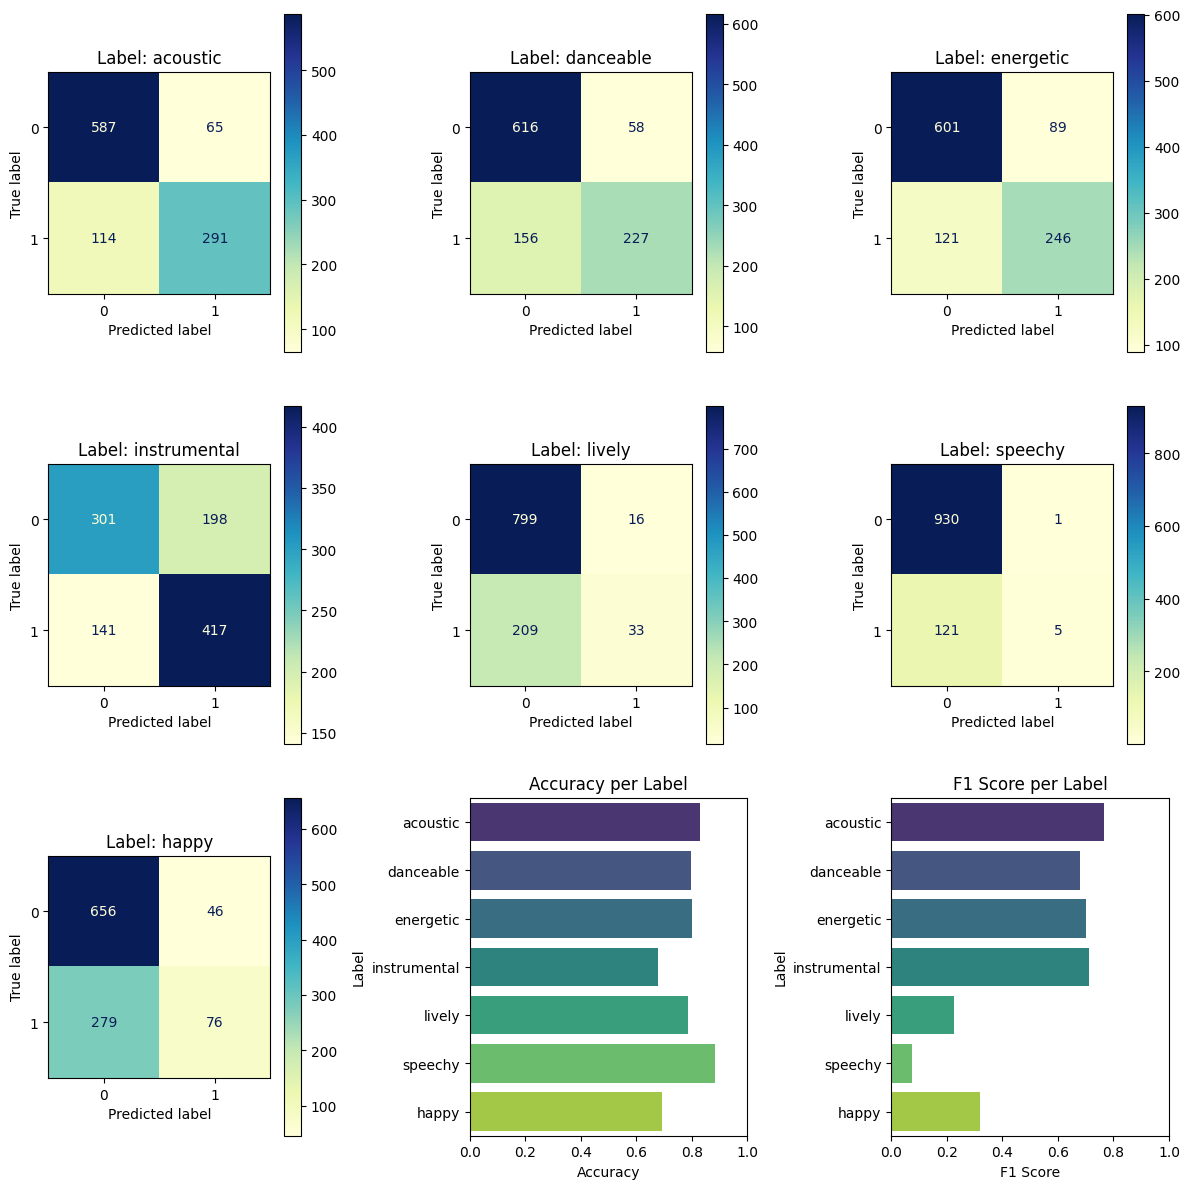

Accuracies:
acoustic: 0.83
danceable: 0.80
energetic: 0.80
instrumental: 0.68
lively: 0.79
speechy: 0.88
happy: 0.69
Average Accuracy: 0.78

F1 Scores:
acoustic: 0.76
danceable: 0.68
energetic: 0.70
instrumental: 0.71
lively: 0.23
speechy: 0.08
happy: 0.32
Average F1 Score: 0.5


In [253]:
print("Random Forest Results (Standard Scaling EchoNest Scores):")
eval_classifier(best_rf_model1, X_test, y1_test, label_names)

Random Forest Results (Gaussian Scaling EchoNest Scores):


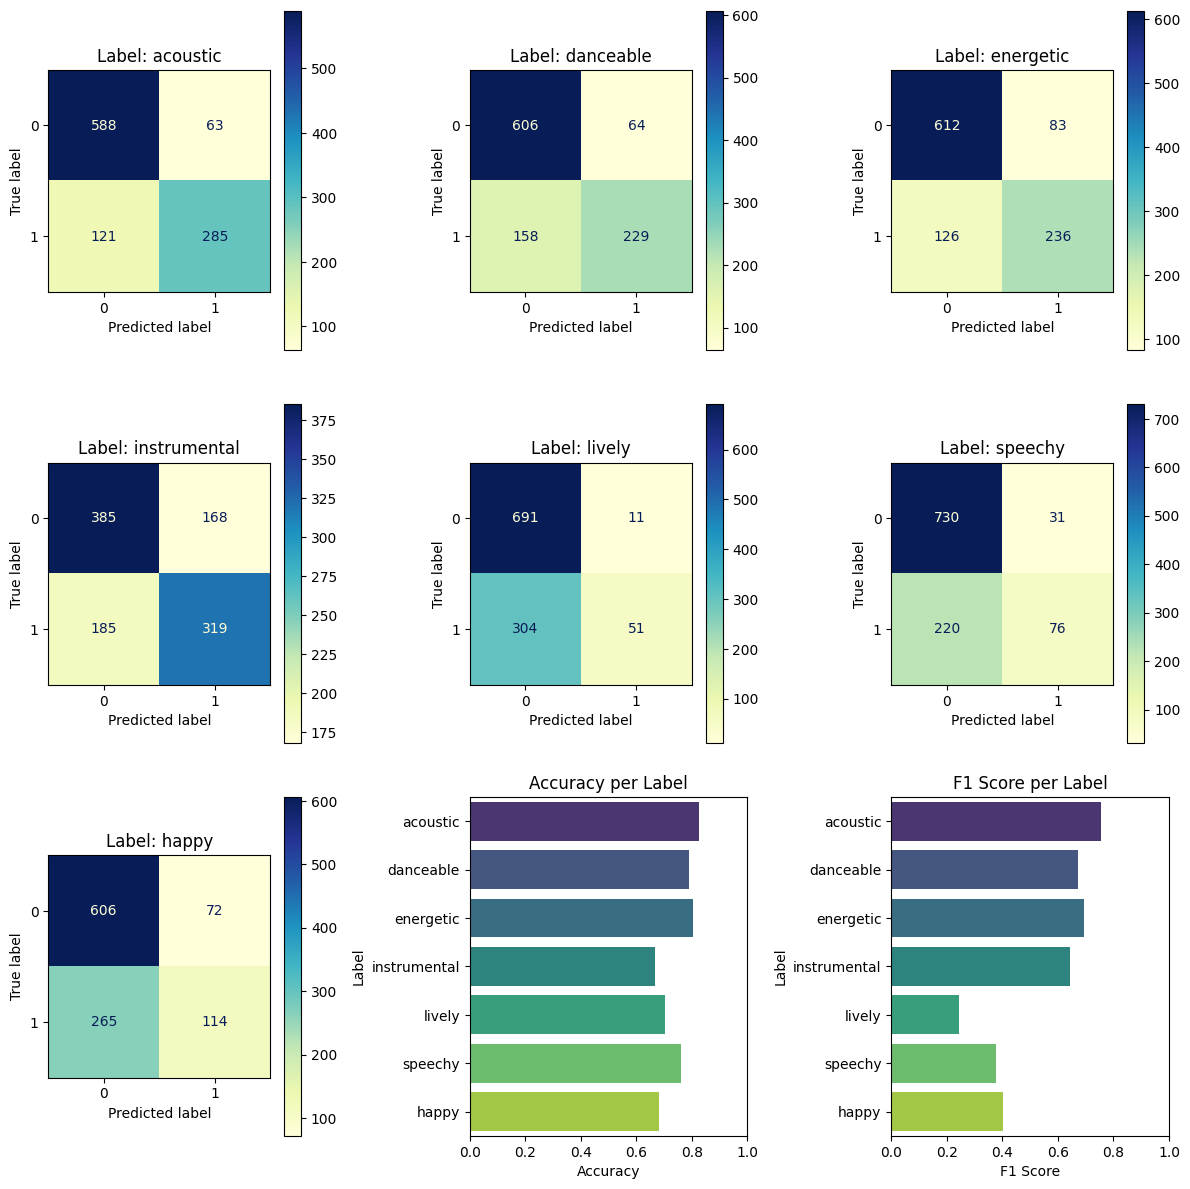

Accuracies:
acoustic: 0.83
danceable: 0.79
energetic: 0.80
instrumental: 0.67
lively: 0.70
speechy: 0.76
happy: 0.68
Average Accuracy: 0.75

F1 Scores:
acoustic: 0.76
danceable: 0.67
energetic: 0.69
instrumental: 0.64
lively: 0.24
speechy: 0.38
happy: 0.40
Average F1 Score: 0.54


In [254]:
print("Random Forest Results (Gaussian Scaling EchoNest Scores):")
eval_classifier(best_rf_model2, X_test, y2_test, label_names)

Neural Net Results (Standard Scaling EchoNest Scores):


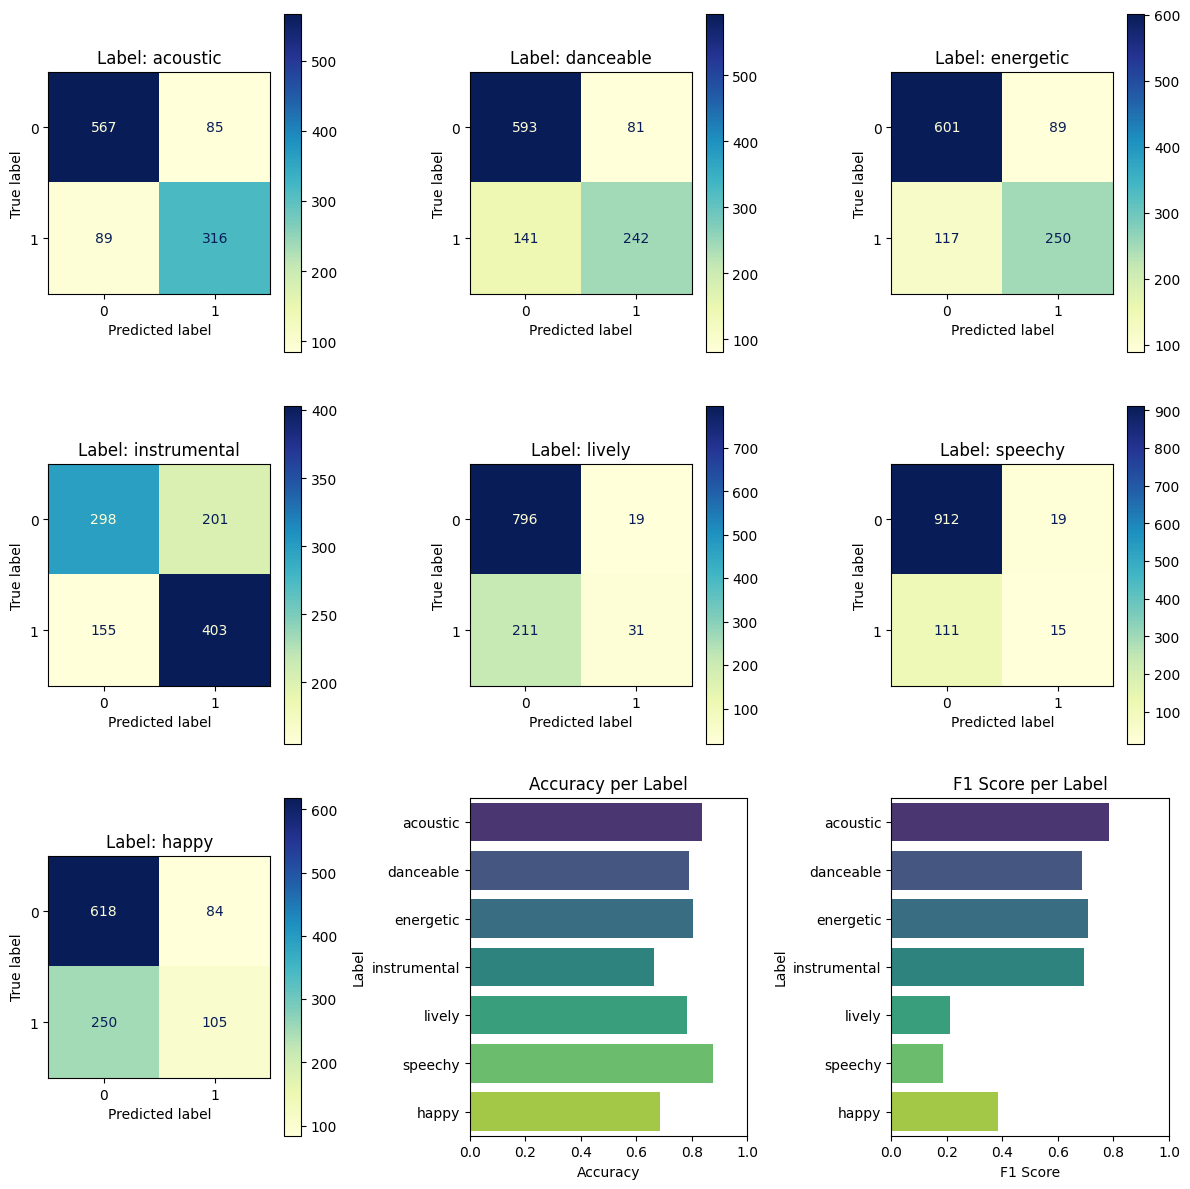

Accuracies:
acoustic: 0.84
danceable: 0.79
energetic: 0.81
instrumental: 0.66
lively: 0.78
speechy: 0.88
happy: 0.68
Average Accuracy: 0.78

F1 Scores:
acoustic: 0.78
danceable: 0.69
energetic: 0.71
instrumental: 0.69
lively: 0.21
speechy: 0.19
happy: 0.39
Average F1 Score: 0.52


In [255]:
print("Neural Net Results (Standard Scaling EchoNest Scores):")
eval_classifier(best_mlp_model1, X_test, y1_test, label_names)

Neural Net Results (Gaussian Scaling EchoNest Scores):


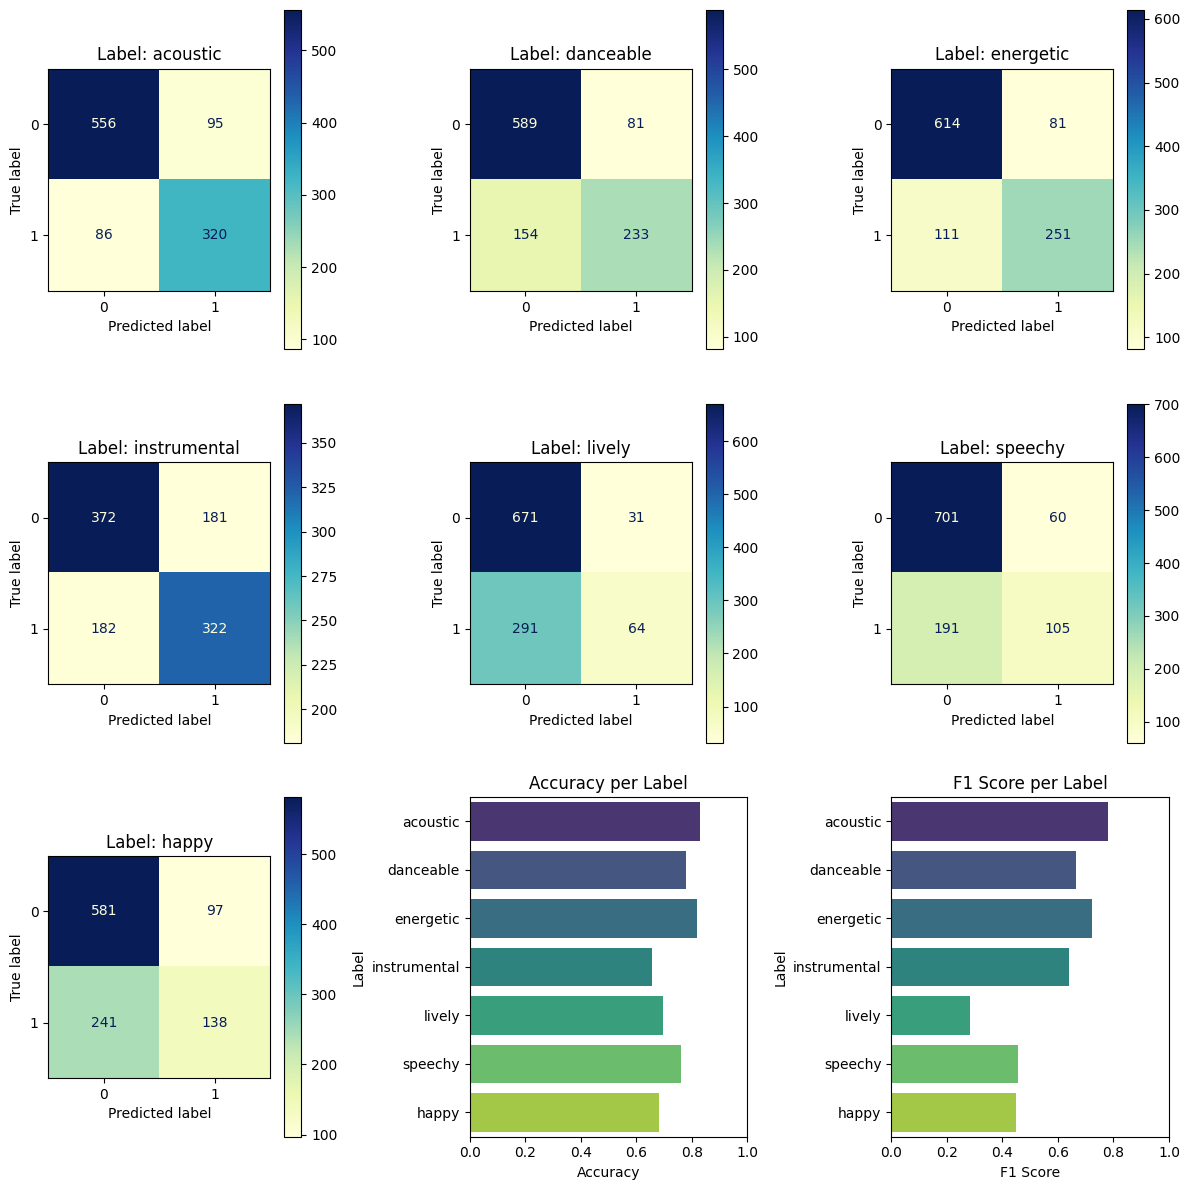

Accuracies:
acoustic: 0.83
danceable: 0.78
energetic: 0.82
instrumental: 0.66
lively: 0.70
speechy: 0.76
happy: 0.68
Average Accuracy: 0.75

F1 Scores:
acoustic: 0.78
danceable: 0.66
energetic: 0.72
instrumental: 0.64
lively: 0.28
speechy: 0.46
happy: 0.45
Average F1 Score: 0.57


In [256]:
print("Neural Net Results (Gaussian Scaling EchoNest Scores):")
eval_classifier(best_mlp_model2, X_test, y2_test, label_names)

Stratified Dummy Classifier Results (Standard Scaling EchoNest Scores):


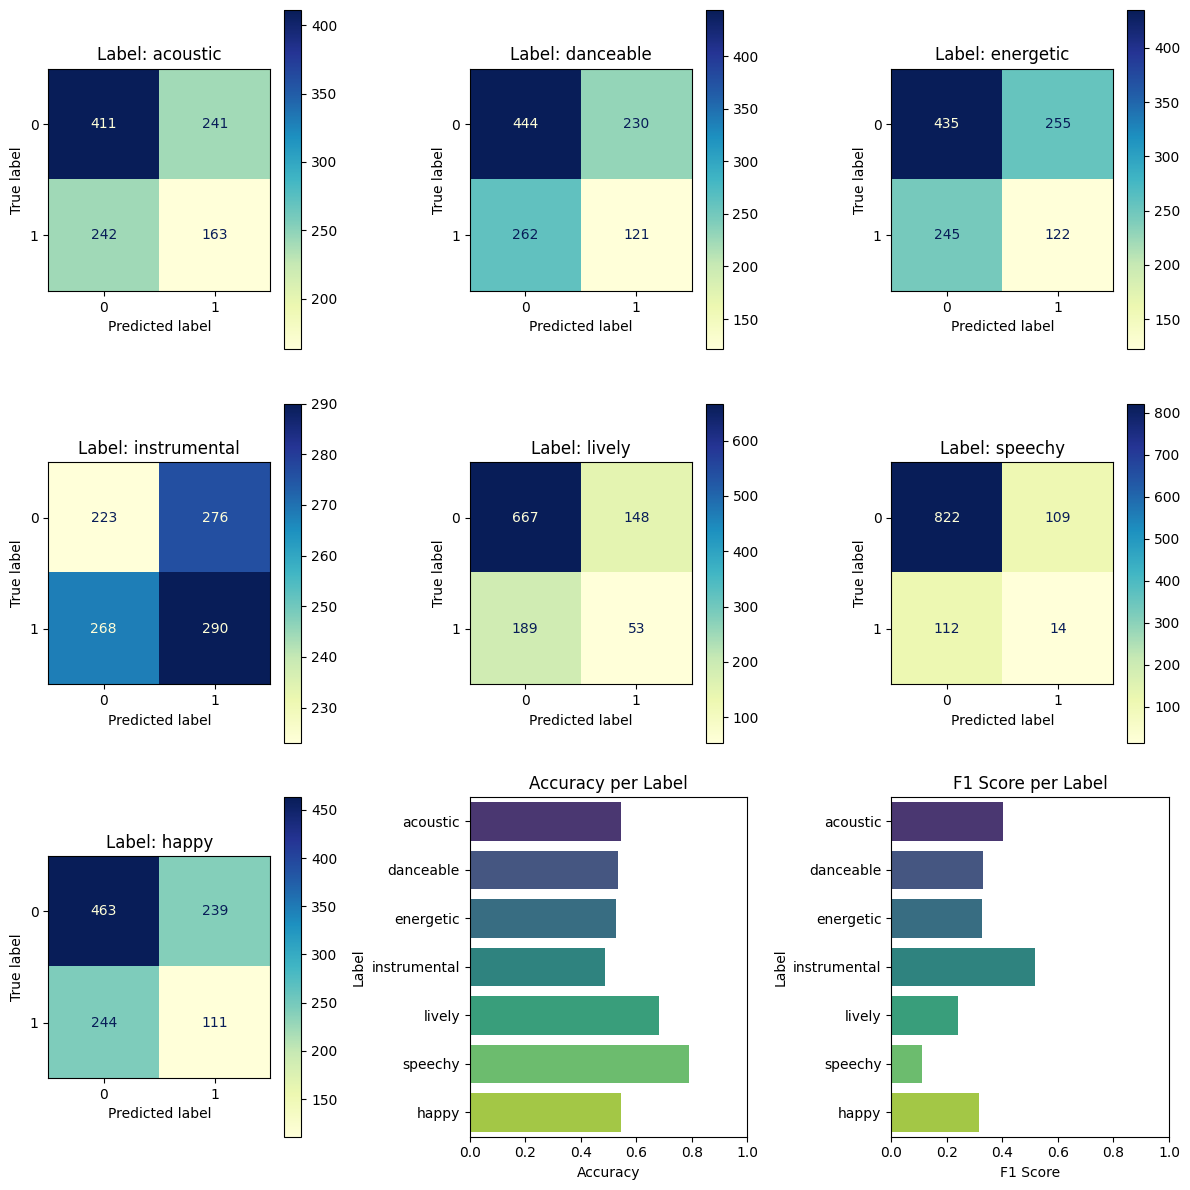

Accuracies:
acoustic: 0.54
danceable: 0.53
energetic: 0.53
instrumental: 0.49
lively: 0.68
speechy: 0.79
happy: 0.54
Average Accuracy: 0.59

F1 Scores:
acoustic: 0.40
danceable: 0.33
energetic: 0.33
instrumental: 0.52
lively: 0.24
speechy: 0.11
happy: 0.31
Average F1 Score: 0.32

Stratified Dummy Classifier Results (Gaussian Scaling EchoNest Scores):


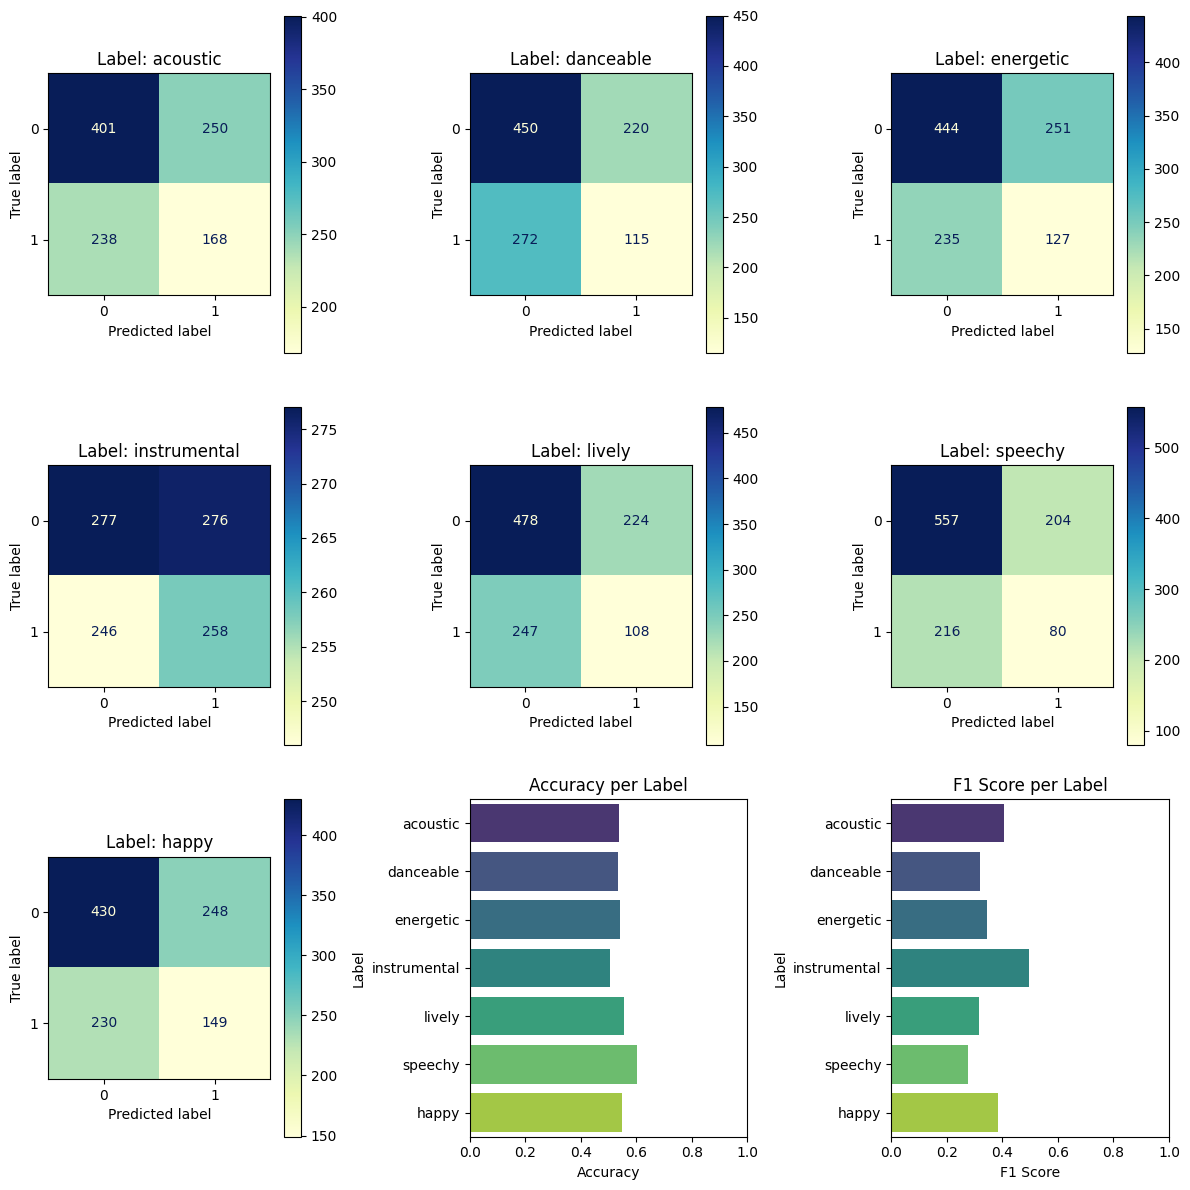

Accuracies:
acoustic: 0.54
danceable: 0.53
energetic: 0.54
instrumental: 0.51
lively: 0.55
speechy: 0.60
happy: 0.55
Average Accuracy: 0.55

F1 Scores:
acoustic: 0.41
danceable: 0.32
energetic: 0.34
instrumental: 0.50
lively: 0.31
speechy: 0.28
happy: 0.38
Average F1 Score: 0.36


In [263]:
# evaluate stratified dummy classifier as benchmark to compare against
dummy1 = DummyClassifier(strategy='stratified').fit(X_train, y1_train)

print("Stratified Dummy Classifier Results (Standard Scaling EchoNest Scores):")
eval_classifier(dummy1, X_test, y1_test, label_names)


dummy2 = DummyClassifier(strategy='stratified').fit(X_train, y2_train)

print("\nStratified Dummy Classifier Results (Gaussian Scaling EchoNest Scores):")
eval_classifier(dummy2, X_test, y2_test, label_names)